In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

from sklearn.model_selection import RandomizedSearchCV
import pickle

# 데이터 준비

In [3]:
path1='/content/drive/MyDrive/ML/train_seriesA.xlsx'
path2='/content/drive/MyDrive/ML/test_seriesA.xlsx'
train=pd.read_excel(path1)
test=pd.read_excel(path2)

In [4]:
y_train=train.loc[:,'seriesB']
y_test=test.loc[:,'seriesB']

In [5]:
#변수중요도에서 뽑은 변수들
col=['netProfit','Started','operatingProfit','mean_Traffic','seed','totalAssets',
     'news','liabilities','tech_rank','employer','Make_month','profit','totalCapital',
     'tech_cnt','Make_year','ceo_info', 'uni_기타','uni_sky', 'uni_해외', 'uni_과학기술',
      'major_경영', 'major_공학', 'major_IT','major_사회', 'major_예체능', 'major_자연', 'major_인문', 'major_의약', 'major_교육']

In [6]:
X_train=train.loc[:,col]
X_test=test.loc[:,col]

# 옵튜나

In [7]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.1 MB/s eta 0:00:00


In [8]:
import optuna

In [10]:
str_kfold = StratifiedKFold(n_splits=5, random_state=777, shuffle=True)

# XGBoost

In [9]:
from xgboost import XGBClassifier

In [11]:
def xgb_objective(trail):
    params = {
        "n_estimators" : trail.suggest_int("n_estimators", 3,1000),
        "criterion": trail.suggest_categorical("criterion", ["gini", "entropy","log_loss"]),
        "max_depth":trail.suggest_int("max_depth", 1, 100),
        "min_samples_leaf":trail.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trail.suggest_int("max_features", 1, X_train.shape[1]),
        "max_leaf_nodes":trail.suggest_int("max_leaf_nodes", 2, 20)
    }
    xgb=XGBClassifier(n_jobs=-1,random_state=777,**params)
    xgb.fit(X_train,y_train)
    scores=cross_val_score(xgb,X_train,y_train,cv=str_kfold,
                         scoring='f1')
    f1_mean=scores.mean()
    return f1_mean

In [12]:
xgb_study=optuna.create_study(direction='maximize')
xgb_study.optimize(xgb_objective,n_trials=50,n_jobs=-1)

[I 2024-02-06 05:15:53,439] A new study created in memory with name: no-name-b6514e9b-ab77-435e-96e2-f732950b6664
[I 2024-02-06 05:15:55,433] Trial 1 finished with value: 0.6413174092893319 and parameters: {'n_estimators': 76, 'criterion': 'log_loss', 'max_depth': 28, 'min_samples_leaf': 16, 'max_features': 27, 'max_leaf_nodes': 7}. Best is trial 1 with value: 0.6413174092893319.
[I 2024-02-06 05:16:00,296] Trial 0 finished with value: 0.649952743453957 and parameters: {'n_estimators': 492, 'criterion': 'log_loss', 'max_depth': 100, 'min_samples_leaf': 20, 'max_features': 11, 'max_leaf_nodes': 20}. Best is trial 0 with value: 0.649952743453957.
[I 2024-02-06 05:16:04,608] Trial 2 finished with value: 0.6392554968766417 and parameters: {'n_estimators': 563, 'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 19, 'max_features': 15, 'max_leaf_nodes': 4}. Best is trial 0 with value: 0.649952743453957.
[I 2024-02-06 05:16:05,250] Trial 3 finished with value: 0.6458736533305878 and pa

In [13]:
xgb_study.best_params

{'n_estimators': 272,
 'criterion': 'gini',
 'max_depth': 54,
 'min_samples_leaf': 3,
 'max_features': 1,
 'max_leaf_nodes': 20}

In [14]:
#모델만들기
opt_xgb=XGBClassifier(n_jobs=-1, random_state=777,
                               **xgb_study.best_params)
opt_xgb.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:20:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "criterion", "max_features", "max_leaf_nodes", "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, criterion='gini', device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=54, max_features=1,
              max_leaf_nodes=20, max_leaves=None, min_child_weight=None,
              min_samples_leaf=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, ...)

In [15]:
#정확도 체크
opt_xgb_ypred=opt_xgb.predict(X_test)
opt_xgb_f1=f1_score(y_test,opt_xgb_ypred)
opt_xgb_f1

0.676470588235294

In [16]:
#모델 저장
filename = "xgb_f1_67.pkl"
pickle.dump(opt_xgb, open( filename, "wb") )

In [17]:
#잘 저장되었는지 확인
new_model = pickle.load( open( "/content/xgb_f1_67.pkl", "rb"))
(new_model.predict(X_test) != opt_xgb.predict(X_test)).sum()

0

# Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
def rf_objective(trail):
    params = {
        "n_estimators" : trail.suggest_int("n_estimators", 3,1000),
        "criterion": trail.suggest_categorical("criterion", ["gini", "entropy","log_loss"]),
        "max_depth":trail.suggest_int("max_depth", 1, 100),
        "min_samples_leaf":trail.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trail.suggest_int("max_features", 1, X_train.shape[1]),
        "max_leaf_nodes":trail.suggest_int("max_leaf_nodes", 2, 20)
    }
    rf=RandomForestClassifier(n_jobs=-1,random_state=777,**params)
    rf.fit(X_train,y_train)
    scores=cross_val_score(rf,X_train,y_train,cv=str_kfold,
                         scoring='f1')
    f1_mean=scores.mean()
    return f1_mean

In [20]:
rf_study=optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective,n_trials=50,n_jobs=-1)

[I 2024-02-06 05:20:38,875] A new study created in memory with name: no-name-1b964c39-f2e3-476c-8b53-b09e6e9572af
[I 2024-02-06 05:20:50,692] Trial 0 finished with value: 0.5893845869071086 and parameters: {'n_estimators': 282, 'criterion': 'gini', 'max_depth': 53, 'min_samples_leaf': 3, 'max_features': 2, 'max_leaf_nodes': 17}. Best is trial 0 with value: 0.5893845869071086.
[I 2024-02-06 05:20:57,289] Trial 2 finished with value: 0.6566227937724542 and parameters: {'n_estimators': 102, 'criterion': 'entropy', 'max_depth': 75, 'min_samples_leaf': 18, 'max_features': 4, 'max_leaf_nodes': 14}. Best is trial 2 with value: 0.6566227937724542.
[I 2024-02-06 05:21:24,599] Trial 1 finished with value: 0.6680482859415339 and parameters: {'n_estimators': 651, 'criterion': 'log_loss', 'max_depth': 93, 'min_samples_leaf': 3, 'max_features': 9, 'max_leaf_nodes': 17}. Best is trial 1 with value: 0.6680482859415339.
[I 2024-02-06 05:21:36,237] Trial 4 finished with value: 0.6598490283291086 and par

In [21]:
rf_study.best_params

{'n_estimators': 847,
 'criterion': 'log_loss',
 'max_depth': 13,
 'min_samples_leaf': 1,
 'max_features': 14,
 'max_leaf_nodes': 14}

In [22]:
opt_rf=RandomForestClassifier(n_jobs=-1, random_state=777,
                              **rf_study.best_params)
opt_rf.fit(X_train,y_train)

RandomForestClassifier(criterion='log_loss', max_depth=13, max_features=14,
                       max_leaf_nodes=14, n_estimators=847, n_jobs=-1,
                       random_state=777)

In [ ]:
opt_rf_ypred=opt_rf.predict(X_test)
opt_rf_f1=f1_score(y_test,opt_rf_ypred)
opt_rf_f1

In [24]:
#모델 저장
filename = "rf_f1_66.pkl"
pickle.dump(opt_rf, open( filename, "wb") )

In [ ]:
#잘 저장되었는지 확인
new_model = pickle.load( open( "/content/rf_f1_66.pkl", "rb"))
(new_model.predict(X_test) != opt_xgb.predict(X_test)).sum()

# LightGBM

In [26]:
from lightgbm import LGBMClassifier

In [ ]:
def lgbm_objective_1(trail):

    params = {
        "n_estimators" : trail.suggest_int("n_estimators", 5,50),
        "criterion": trail.suggest_categorical("criterion", ["gini", "entropy","log_loss"]),
        "max_depth":trail.suggest_int("max_depth", 1,50),
        "min_samples_leaf":trail.suggest_int("min_samples_leaf", 1,50),
        "max_features": trail.suggest_int("max_features", 1, X_train.shape[1]),
        "max_leaf_nodes":trail.suggest_int("max_leaf_nodes", 1,300)
                                      }

    lgbm_opt = LGBMClassifier( n_jobs=-1, random_state=777,**params )

    lgbm_opt.fit(X_train, y_train)
    scores = cross_val_score( lgbm_opt, X_train, y_train, cv=str_kfold,scoring="f1")

    f1_mean = scores.mean()
    return f1_mean

In [ ]:
lgbm_opt_study=optuna.create_study(direction='maximize')
lgbm_opt_study.optimize(lgbm_objective_1,n_trials=50,n_jobs=-1)

In [ ]:
lgbm_opt_study.best_params

In [ ]:
opt_lgbm=LGBMClassifier(n_jobs=-1, random_state=777,
                               **lgbm_opt_study.best_params)
opt_lgbm.fit(X_train,y_train)

In [ ]:
opt_lgbm_ypred=opt_lgbm.predict(X_test)
opt_lgbm_f1=f1_score(y_test,opt_lgbm_ypred)
opt_lgbm_f1

In [ ]:
filename = "MP_lgbm_73.pkl"
pickle.dump(opt_lgbm, open(filename, "wb"))

In [ ]:
#잘 저장되었는지 확인
new_model = pickle.load( open( "/content/drive/MyDrive/ML/모델/MP_lgbm_73.pkl", "rb"))
(new_model.predict(X_test) != opt_xgb.predict(X_test)).sum()

# LGBM으로 분석

In [28]:
#학습
new_model.fit(X_train,y_train)

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=23. Current value: min_data_in_leaf=23
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=108 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=23. Current value: min_data_in_leaf=23
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=108 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] 

LGBMClassifier(criterion='log_loss', max_depth=28, max_features=18,
               max_leaf_nodes=108, min_samples_leaf=23, n_estimators=45,
               n_jobs=-1, random_state=777)

In [29]:
#예측
new_model_ypred1=pd.DataFrame(new_model.predict_proba(X_test))
new_model_ypred2=pd.DataFrame(new_model.predict(X_test))

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=23. Current value: min_data_in_leaf=23
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=108 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=23. Current value: min_data_in_leaf=23
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=108 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [30]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,new_model_ypred2)

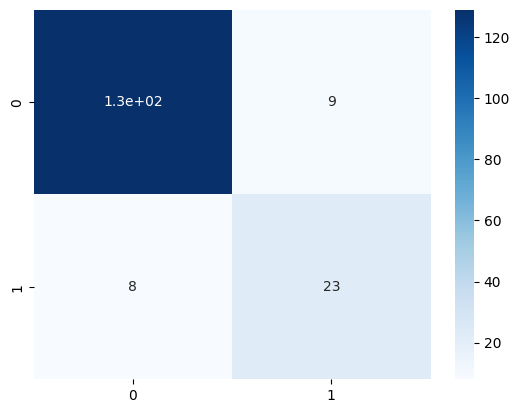

In [31]:
sns.heatmap(cm, annot=True, cmap='Blues')
plt.show()

In [34]:
# 특성 중요도 값 확인
importances = new_model.feature_importances_

# 중요도를 기준으로 특성의 순서를 얻기
indices = importances.argsort()[::-1]

# 중요도가 높은 순서대로 특성 이름과 중요도 출력
for i in indices:
  print(f"{X_train.columns[i]} {importances[i]}")

seed 159
liabilities 133
employer 132
Started 124
totalCapital 115
mean_Traffic 103
netProfit 102
totalAssets 89
operatingProfit 86
profit 83
news 74
Make_month 50
tech_cnt 41
tech_rank 29
ceo_info 11
major_IT 4
Make_year 3
uni_sky 3
major_의약 0
uni_기타 0
uni_해외 0
uni_과학기술 0
major_경영 0
major_공학 0
major_사회 0
major_예체능 0
major_자연 0
major_인문 0
major_교육 0


In [35]:
#실패사례
new_model.predict(X_test)[57]  #0

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=23. Current value: min_data_in_leaf=23
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=108 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


0

In [36]:
new_model.predict_proba(X_test)[57]

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=23. Current value: min_data_in_leaf=23
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=108 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([0.99756318, 0.00243682])

In [37]:
#성공사례
new_model.predict(X_test)[80]  #1

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=23. Current value: min_data_in_leaf=23
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=108 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


1

In [38]:
new_model.predict_proba(X_test)[80]

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=23. Current value: min_data_in_leaf=23
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=108 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([0.16253614, 0.83746386])